# Wrangle that Data

<ul>
    <li><a href="#Gather">Gather</a></li>
    <li>
        <a href="#Assess">Assess</a>
        <ul>
            <li><a href="#Tweet-archive">Tweet archive</a></li>
            <li><a href="#Image-predictions">Image predictions</a></li>
            <li><a href="#Extended-tweets">Extended tweets</a></li>
            <li><a href="#Users">Users</a></li>
            <li><a href="#Problems">Problems</a></li>
        </ul>
    </li>
    <li>
        <a href="#Clean">Clean</a>
        <ul>
            <li><a href="#Define">Define</a></li>
            <li><a href="#Act">Act</a></li>
        </ul>
    </li>
    <li><a href="#Save">Save</a></li>
    <li><a href="#Analyze">Analyze</a></li>
</ul>

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import re
import requests
import seaborn as sns
import time
import tweepy
from glob import glob

In [2]:
%matplotlib inline

## Gather

In [3]:
# load secrets
# 'secrets.json' is ignored by git'
with open('secrets.json') as secrets_file:
    secrets = json.load(secrets_file)

In [4]:
tweets_raw = pd.read_csv('twitter-archive-enhanced.csv')

In [5]:
image_predictions_file_name = 'image-predictions.tsv'
image_predictions_source_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [6]:
# make sure image predictions are downloaded
if not os.path.exists(image_predictions_file_name):
    response = requests.get(image_predictions_source_url, stream=True)
    with open(image_predictions_file_name, mode='w', encoding='utf-8') as dest_file:
        for chunk in response.iter_content(decode_unicode=True):
            # filter out keep-alive new chunks
            if chunk:
                dest_file.write(chunk)

In [7]:
image_predictions_raw = pd.read_csv(image_predictions_file_name, sep='\t')

In [8]:
# get twitter API
consumer_key = secrets['twitter']['consumerApiKey']
consumer_secret = secrets['twitter']['consumerSecret']
access_token = secrets['twitter']['accessToken']
access_secret = secrets['twitter']['accessTokenSecret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

twitter_api = tweepy.API(
    auth,
    wait_on_rate_limit=True,
    wait_on_rate_limit_notify=True)

In [9]:
status_ids = (tweets_raw['expanded_urls']
    .str.extract(r'^http[s]?://twitter\.com/dog_rates/status/(\d+)', expand=False)
    .dropna()
    .drop_duplicates()
    .astype(str))
status_count = len(status_ids)
len(status_ids)

1967

In [10]:
already_downloaded_statuses = (
    pd.Series(os.listdir('extended-statuses'))
        .str.extract(r'^(\d+)\.json$', expand=False)
        .dropna())
len(already_downloaded_statuses)

1967

In [11]:
statuses_to_download = set(status_ids) - set(already_downloaded_statuses)
len(statuses_to_download)

0

In [12]:
print('Pulling twitter statuses.')
i = 0
for status_id in statuses_to_download:
    try:
        status = api.get_status(status_id, tweet_mode='extended')
        with open(f'extended-statuses/{status_id}.json', 'w') as target_file:
            json.dump(status._json, target_file, indent=2)
    except tweepy.RateLimitError as rle:
        print(rle)
        time.sleep(60 * 5)
        status = api.get_status(status_id, tweet_mode='extended')
        with open(f'extended-statuses/{status_id}.json', 'w') as target_file:
            json.dump(status._json, target_file, indent=2)
    except Exception as e:
        print(e)
    i += 1
    if i % 100 == 0:
        print(f'Statuses pulled so far: {i}.')
        time.sleep(60)
print('Done.')

Pulling twitter statuses.
Done.


In [13]:
already_downloaded_statuses = (
    pd.Series(os.listdir('extended-statuses'))
        .str.extract(r'^(\d+)\.json$', expand=False)
        .dropna())
len(already_downloaded_statuses)

1967

In [14]:
extended_tweets_arr = []
users_arr = []
for file_path in glob('extended-statuses/*.json'):
    with open(file_path, 'r', encoding='utf-8') as status_file:
        status = json.load(status_file)
    extended_tweets_arr.append({
        'tweet_id': status['id'],
        'text': status['full_text'],
        'source': status['source'],
        'in_reply_to_status_id': status['in_reply_to_status_id'],
        'in_reply_to_user_id': status['in_reply_to_user_id'],
        'retweet_count': status['retweet_count'],
        'favorite_count': status['favorite_count'],
        'user_id': status['user']['id']})
    users_arr.append({
        'user_id': status['user']['id'],
        'followers_count': status['user']['followers_count'],
        'friends_count': status['user']['friends_count'],
        'listed_count': status['user']['listed_count'],
        'favourites_count': status['user']['favourites_count'],
        'statuses_count': status['user']['statuses_count']})
extended_tweets_raw = pd.DataFrame(extended_tweets_arr)
users_raw = pd.DataFrame(users_arr)

## Assess

### Tweet archive

In [15]:
tweets_raw

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [16]:
tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [17]:
tweets_raw['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
Oliver         11
Lola           10
Penny          10
Tucker         10
Bo              9
Winston         9
Sadie           8
the             8
Toby            7
Bailey          7
an              7
Daisy           7
Buddy           7
Dave            6
Oscar           6
Koda            6
Bella           6
Rusty           6
Leo             6
Scout           6
Milo            6
Jack            6
Stanley         6
Jax             6
Louis           5
             ... 
Christoper      1
Kuyu            1
Milky           1
Wiggles         1
Anthony         1
Rambo           1
Rooney          1
Karll           1
Jordy           1
Travis          1
Birf            1
Dook            1
Zuzu            1
Fiji            1
Edgar           1
Ralph           1
Torque          1
Kanu            1
Brockly         1
Brady           1
Gunner          1
Dot             1
Lilah           1
life            1
Dobby     

In [18]:
not_names = (
    tweets_raw['name']
    .where(lambda n: n.str.slice(0, 1) == n.str.slice(0, 1).str.lower())
    .dropna()
    .unique())
not_names

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [19]:
tweets_raw['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [20]:
tweets_raw['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [21]:
tweets_raw['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [22]:
tweets_raw['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [23]:
tweets_raw['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [24]:
tweets_raw['tweet_id'].value_counts().head()

749075273010798592    1
741099773336379392    1
798644042770751489    1
825120256414846976    1
769212283578875904    1
Name: tweet_id, dtype: int64

In [25]:
tweets_raw['in_reply_to_status_id'].value_counts().head()

6.671522e+17    2
8.562860e+17    1
8.131273e+17    1
6.754971e+17    1
6.827884e+17    1
Name: in_reply_to_status_id, dtype: int64

In [26]:
tweets_raw['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [27]:
tweets_raw['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### Image predictions

In [28]:
image_predictions_raw

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [29]:
image_predictions_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [30]:
image_predictions_raw['tweet_id'].value_counts().head()

685532292383666176    1
826598365270007810    1
692158366030913536    1
714606013974974464    1
715696743237730304    1
Name: tweet_id, dtype: int64

In [31]:
image_predictions_raw['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Siberian_husky                20
Staffordshire_bullterrier     20
German_shepherd               20
web_site                      19
Cardigan                      19
teddy                         18
Shetland_sheepdog             18
beagle                        18
Eskimo_dog                    18
Maltese_dog                   18
Lakeland_terrier              17
Shih-Tzu                      17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

### Extended tweets

In [32]:
extended_tweets_raw

,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,source,text,tweet_id,user_id
0,1563,NaN,NaN,614,"<a href=""http://twitter.com/download/iphone"" r...",Rare submerged pup here. Holds breath for a lo...,674632714662858753,4196983835
1,2965,NaN,NaN,1009,"<a href=""http://twitter.com/download/iphone"" r...",This is Tug. He's not required to wear the con...,678774928607469569,4196983835
2,24293,NaN,NaN,4901,"<a href=""http://twitter.com/download/iphone"" r...",This is Kevin. He's just so happy. 13/10 what ...,884562892145688576,4196983835
3,1264,NaN,NaN,523,"<a href=""http://twitter.com/download/iphone"" r...",*screams for a little bit and then crumples to...,670717338665226240,4196983835
4,31014,NaN,NaN,9504,"<a href=""http://twitter.com/download/iphone"" r...",We usually don't rate polar bears but this one...,845812042753855489,4196983835
5,903,NaN,NaN,381,"<a href=""http://twitter.com/download/iphone"" r...",This is Bubba. He's a Titted Peebles Aorta. Ev...,672160042234327040,4196983835
6,1962,NaN,NaN,1149,"<a href=""http://twitter.com/download/iphone"" r...",This is Erik. He's fucken massive. But also ki...,667886921285246976,4196983835
7,2404,NaN,NaN,964,"<a href=""http://twitter.com/download/iphone"" r...",This is Pepper. She's not fully comfortable ri...,675845657354215424,4196983835
8,240,NaN,NaN,59,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is a rare Hungarian Pinot named Jessiga. ...,667773195014021121,4196983835
9,1692,NaN,NaN,386,"<a href=""http://twitter.com/download/iphone"" r...",This is Ralphson. He's very confused. Wonderin...,704347321748819968,4196983835


In [33]:
extended_tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 0 to 1966
Data columns (total 8 columns):
favorite_count           1967 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
retweet_count            1967 non-null int64
source                   1967 non-null object
text                     1967 non-null object
tweet_id                 1967 non-null int64
user_id                  1967 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 123.0+ KB


In [34]:
extended_tweets_raw['tweet_id'].value_counts().head()

685532292383666176    1
743510151680958465    1
805487436403003392    1
672466075045466113    1
685315239903100929    1
Name: tweet_id, dtype: int64

In [35]:
extended_tweets_raw['in_reply_to_status_id'].value_counts().head()

6.671522e+17    2
8.558181e+17    1
6.753494e+17    1
6.747934e+17    1
6.747522e+17    1
Name: in_reply_to_status_id, dtype: int64

In [36]:
extended_tweets_raw['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1928
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [37]:
extended_tweets_raw['user_id'].value_counts()

4196983835    1967
Name: user_id, dtype: int64

### Users

In [38]:
users_raw.head()

,favourites_count,followers_count,friends_count,listed_count,statuses_count,user_id
0,134004,6889373,8,4389,7100,4196983835
1,134004,6889502,8,4475,7100,4196983835
2,134004,6889503,8,4477,7100,4196983835
3,134004,6889443,8,4414,7100,4196983835
4,134004,6889431,8,4413,7100,4196983835


In [39]:
users_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 0 to 1966
Data columns (total 6 columns):
favourites_count    1967 non-null int64
followers_count     1967 non-null int64
friends_count       1967 non-null int64
listed_count        1967 non-null int64
statuses_count      1967 non-null int64
user_id             1967 non-null int64
dtypes: int64(6)
memory usage: 92.3 KB


### Problems

- Tidiness:
    - In tweets archive dog "stages" are datapoints, but should be observations (and categorical);
    - tweets archive, extended tweets and image pradictions should be single dataset;
    - (alternatively twitter related information in tweets archive and extended tweets could go into one dataset and dog related information in tweets archive and image predictions could go to another as this could be seen as two separate concenrs. In our case I think all this is part of same observation, so I decided against splitting data into two datasets);

- Quality:
    - tweets archive:
        - `retweet_status_id` and `retweeted_status_user_id` are in scientific notation (also float64);
        - False dog names (captured in `not_names`);
        - Columns `name`, `doggo`, `floofer`, `pupper`, `puppo` poluted with 'None' instead of np.NaN;
        - `source` would be fine as just inner text of anchor tag;
        - `source` could be categorical;
        - `timestamp` and `retweeted_status_timestamp` are objects, but represent datetimes;
        - `rating_denominator` is not always 10;
    - image_predictions:
        - In column names p1, p2, p3 should be prediction1, prediction2, prediction3;
        - In column names conf should be conficende;
        - Predicted breed capitalization varies;
        - Predicted breeds are with underscores insted of spaces;
    - extended_tweets:
        - `in_reply_to_status_id` and `in_reply_to_user_id` should be integers (or at least be represented in non-scientific notation);
        - `source` has same issues as in tweets archive;
        - `user_id` has single unique value;
    - users:
        - Turns out all tweets came from one user. This dataset is useless;

## Clean

### Define

- In image prediction column names replace p1, p2, p3 with prediction1, prediction2, prediction3;
- In image prediction  column names replace conf to confidence;
- In columns `name`, `doggo`, `floofer`, `pupper`, `puppo` replace 'None' with np.NaN;
- Melt `doggo`, `floofer`, `pupper`, `puppo` column into `stage` column;
- Merge tweet archive, extended tweets and image predictions into single dataset;
- Calculate `rating_with_denominator_10` column;
- Replace false dog names (captured in `not_names`) with np.NaN;
- Extract inner text of anchor tag in `source` and replace the value with it;
- Replace underscores in breed predictions and lowercase it;
- Convert `source` to category;
- Convert `timestamp` and `retweeted_status_timestamp` to datetime;
- Convert `retweeted_status_id`, `retweeted_status_user_id`, `in_reply_to_status_id` and `in_reply_to_user_id` to strings (I'd rather have them as integers, but we [can't have NAs in integer series](http://pandas.pydata.org/pandas-docs/stable/gotchas.html#support-for-integer-na), and these are identifier values, so representation is important);
- Drop `user_id`;

### Act

In [40]:
tweets = tweets_raw.copy()
extended_tweets = extended_tweets_raw.copy()
image_predictions = image_predictions_raw.copy()

#### In image prediction column names replace p1, p2, p3 with prediction1, prediction2, prediction3

In [41]:
img_pred_columns = [(col, re.sub(r'^p(\d)', 'prediction\\1', col)) for col in image_predictions.columns]

#### In image prediction column names replace conf to confidence

In [42]:
img_pred_columns = [(col[0], re.sub(r'conf$', 'confidence', col[1])) for col in img_pred_columns]

In [43]:
img_pred_columns = dict(img_pred_columns)

In [44]:
image_predictions = image_predictions.rename(columns=img_pred_columns)

In [45]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                  2075 non-null int64
jpg_url                   2075 non-null object
img_num                   2075 non-null int64
prediction1               2075 non-null object
prediction1_confidence    2075 non-null float64
prediction1_dog           2075 non-null bool
prediction2               2075 non-null object
prediction2_confidence    2075 non-null float64
prediction2_dog           2075 non-null bool
prediction3               2075 non-null object
prediction3_confidence    2075 non-null float64
prediction3_dog           2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### In columns name, doggo, floofer, pupper, puppo replace 'None' with np.NaN

In [46]:
tweets[['name', 'doggo', 'floofer', 'pupper', 'puppo']] = (
    tweets[['name', 'doggo', 'floofer', 'pupper', 'puppo']]
    .replace('None', np.NaN))

In [47]:
tweets

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,NaN,NaN,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN,NaN,NaN,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,NaN,NaN,NaN


#### Melt doggo, floofer, pupper, puppo column into stage column

In [48]:
dog_stages = tweets[['doggo', 'floofer', 'pupper', 'puppo']]
tweets['stage'] = (
    dog_stages
    .notnull()
    .idxmax(1)
    .pipe(lambda row: dog_stages.lookup(row.index, row.values)))

In [49]:
tweets[tweets['stage'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,NaN,NaN,NaN,doggo
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,NaN,NaN,NaN,NaN,puppo,puppo
14,889531135344209921,NaN,NaN,2017-07-24 17:02:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889531135...,13,10,Stuart,NaN,NaN,NaN,puppo,puppo
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12,10,Roscoe,NaN,NaN,pupper,NaN,pupper
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo,NaN,NaN,NaN,doggo
46,883360690899218434,NaN,NaN,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,NaN,floofer,NaN,NaN,floofer
49,882762694511734784,NaN,NaN,2017-07-06 00:46:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He's quite the cheeky pupper. Alr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882762694...,12,10,Gus,NaN,NaN,pupper,NaN,pupper
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,NaN,NaN,pupper,NaN,pupper
71,878776093423087618,NaN,NaN,2017-06-25 00:45:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Snoopy. He's a proud #PrideMonthPuppo....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878776093...,13,10,Snoopy,NaN,NaN,NaN,puppo,puppo
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,NaN,NaN,NaN,pupper,NaN,pupper


In [50]:
tweets = tweets.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

#### Merge tweet archive, extended tweets and image predictions into single dataset

In [51]:
set(tweets.columns) & set(extended_tweets.columns)

{'in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'text', 'tweet_id'}

I trust 'text', in_reply_to_status_id', 'in_reply_to_user_id', 'source' values more in dataset I pulled myself, so I'll keep the ones from extended tweets.

In [52]:
tweets = tweets.drop(['text', 'in_reply_to_status_id', 'in_reply_to_user_id', 'source'], axis = 1)

In [53]:
set(tweets.columns) & set(image_predictions.columns)

{'tweet_id'}

In [54]:
set(extended_tweets.columns) & set(image_predictions.columns)

{'tweet_id'}

In [55]:
master = (
    extended_tweets
    .merge(tweets, how='inner', on='tweet_id')
    .merge(image_predictions, how='inner', on='tweet_id'))

In [56]:
master

,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,source,text,tweet_id,user_id,timestamp,retweeted_status_id,...,img_num,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog
0,1563,NaN,NaN,614,"<a href=""http://twitter.com/download/iphone"" r...",Rare submerged pup here. Holds breath for a lo...,674632714662858753,4196983835,2015-12-09 16:52:27 +0000,NaN,...,1,jellyfish,0.432748,False,goldfish,0.113111,False,coral_reef,0.087047,False
1,2965,NaN,NaN,1009,"<a href=""http://twitter.com/download/iphone"" r...",This is Tug. He's not required to wear the con...,678774928607469569,4196983835,2015-12-21 03:12:08 +0000,NaN,...,1,Pembroke,0.194681,True,toy_poodle,0.121821,True,Pomeranian,0.096843,True
2,24293,NaN,NaN,4901,"<a href=""http://twitter.com/download/iphone"" r...",This is Kevin. He's just so happy. 13/10 what ...,884562892145688576,4196983835,2017-07-11 00:00:02 +0000,NaN,...,1,pug,0.546406,True,French_bulldog,0.404291,True,Brabancon_griffon,0.044002,True
3,1264,NaN,NaN,523,"<a href=""http://twitter.com/download/iphone"" r...",*screams for a little bit and then crumples to...,670717338665226240,4196983835,2015-11-28 21:34:09 +0000,NaN,...,1,Pomeranian,0.368161,True,Pekinese,0.350973,True,golden_retriever,0.114902,True
4,31014,NaN,NaN,9504,"<a href=""http://twitter.com/download/iphone"" r...",We usually don't rate polar bears but this one...,845812042753855489,4196983835,2017-03-26 01:38:00 +0000,NaN,...,1,Samoyed,0.979803,True,chow,0.015923,True,white_wolf,0.001303,False
5,903,NaN,NaN,381,"<a href=""http://twitter.com/download/iphone"" r...",This is Bubba. He's a Titted Peebles Aorta. Ev...,672160042234327040,4196983835,2015-12-02 21:06:56 +0000,NaN,...,1,pug,0.561027,True,French_bulldog,0.222114,True,Labrador_retriever,0.065456,True
6,1962,NaN,NaN,1149,"<a href=""http://twitter.com/download/iphone"" r...",This is Erik. He's fucken massive. But also ki...,667886921285246976,4196983835,2015-11-21 02:07:05 +0000,NaN,...,1,Pomeranian,0.800432,True,Pekinese,0.168445,True,Chihuahua,0.008950,True
7,2404,NaN,NaN,964,"<a href=""http://twitter.com/download/iphone"" r...",This is Pepper. She's not fully comfortable ri...,675845657354215424,4196983835,2015-12-13 01:12:15 +0000,NaN,...,1,pug,0.883952,True,Boston_bull,0.011057,True,French_bulldog,0.009840,True
8,240,NaN,NaN,59,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is a rare Hungarian Pinot named Jessiga. ...,667773195014021121,4196983835,2015-11-20 18:35:10 +0000,NaN,...,1,West_Highland_white_terrier,0.360465,True,pug,0.093494,True,ice_bear,0.069038,False
9,1692,NaN,NaN,386,"<a href=""http://twitter.com/download/iphone"" r...",This is Ralphson. He's very confused. Wonderin...,704347321748819968,4196983835,2016-02-29 16:47:42 +0000,NaN,...,1,teddy,0.233378,False,feather_boa,0.088474,False,Brittany_spaniel,0.082917,True


In [57]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 0 to 1965
Data columns (total 28 columns):
favorite_count                1966 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
retweet_count                 1966 non-null int64
source                        1966 non-null object
text                          1966 non-null object
tweet_id                      1966 non-null int64
user_id                       1966 non-null int64
timestamp                     1966 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1966 non-null object
rating_numerator              1966 non-null int64
rating_denominator            1966 non-null int64
name                          1426 non-null object
stage                         300 non-null object
jpg_url                       1966 non-nul

All rows where `retweeted_status_*` columns had values fell out. Change of plans. Let's drop them.

#### Calculate rating_with_denominator_10 column

In [58]:
master['rating_with_denominator_10'] = (master['rating_numerator'] / master['rating_denominator'] * 10).astype(int)

In [59]:
master

,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,source,text,tweet_id,user_id,timestamp,retweeted_status_id,...,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog,rating_with_denominator_10
0,1563,NaN,NaN,614,"<a href=""http://twitter.com/download/iphone"" r...",Rare submerged pup here. Holds breath for a lo...,674632714662858753,4196983835,2015-12-09 16:52:27 +0000,NaN,...,jellyfish,0.432748,False,goldfish,0.113111,False,coral_reef,0.087047,False,5
1,2965,NaN,NaN,1009,"<a href=""http://twitter.com/download/iphone"" r...",This is Tug. He's not required to wear the con...,678774928607469569,4196983835,2015-12-21 03:12:08 +0000,NaN,...,Pembroke,0.194681,True,toy_poodle,0.121821,True,Pomeranian,0.096843,True,11
2,24293,NaN,NaN,4901,"<a href=""http://twitter.com/download/iphone"" r...",This is Kevin. He's just so happy. 13/10 what ...,884562892145688576,4196983835,2017-07-11 00:00:02 +0000,NaN,...,pug,0.546406,True,French_bulldog,0.404291,True,Brabancon_griffon,0.044002,True,13
3,1264,NaN,NaN,523,"<a href=""http://twitter.com/download/iphone"" r...",*screams for a little bit and then crumples to...,670717338665226240,4196983835,2015-11-28 21:34:09 +0000,NaN,...,Pomeranian,0.368161,True,Pekinese,0.350973,True,golden_retriever,0.114902,True,12
4,31014,NaN,NaN,9504,"<a href=""http://twitter.com/download/iphone"" r...",We usually don't rate polar bears but this one...,845812042753855489,4196983835,2017-03-26 01:38:00 +0000,NaN,...,Samoyed,0.979803,True,chow,0.015923,True,white_wolf,0.001303,False,13
5,903,NaN,NaN,381,"<a href=""http://twitter.com/download/iphone"" r...",This is Bubba. He's a Titted Peebles Aorta. Ev...,672160042234327040,4196983835,2015-12-02 21:06:56 +0000,NaN,...,pug,0.561027,True,French_bulldog,0.222114,True,Labrador_retriever,0.065456,True,8
6,1962,NaN,NaN,1149,"<a href=""http://twitter.com/download/iphone"" r...",This is Erik. He's fucken massive. But also ki...,667886921285246976,4196983835,2015-11-21 02:07:05 +0000,NaN,...,Pomeranian,0.800432,True,Pekinese,0.168445,True,Chihuahua,0.008950,True,11
7,2404,NaN,NaN,964,"<a href=""http://twitter.com/download/iphone"" r...",This is Pepper. She's not fully comfortable ri...,675845657354215424,4196983835,2015-12-13 01:12:15 +0000,NaN,...,pug,0.883952,True,Boston_bull,0.011057,True,French_bulldog,0.009840,True,10
8,240,NaN,NaN,59,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is a rare Hungarian Pinot named Jessiga. ...,667773195014021121,4196983835,2015-11-20 18:35:10 +0000,NaN,...,West_Highland_white_terrier,0.360465,True,pug,0.093494,True,ice_bear,0.069038,False,8
9,1692,NaN,NaN,386,"<a href=""http://twitter.com/download/iphone"" r...",This is Ralphson. He's very confused. Wonderin...,704347321748819968,4196983835,2016-02-29 16:47:42 +0000,NaN,...,teddy,0.233378,False,feather_boa,0.088474,False,Brittany_spaniel,0.082917,True,10


#### Replace false dog names (captured in not_names) with np.NaN

In [60]:
master['name'] = np.where(np.isin(master['name'], not_names), np.NaN, master['name'])

In [61]:
master[np.isin(master['name'], not_names)]

,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,source,text,tweet_id,user_id,timestamp,retweeted_status_id,...,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog,rating_with_denominator_10


#### Extract inner text of anchor tag in source and replace the value with it

In [62]:
master['source'] = master['source'].str.extract(r'<a .+?>(.+)</a>', expand=False)

In [63]:
master['source'].value_counts()

Twitter for iPhone    1927
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

#### Replace underscores in breed predictions and lowercase it

In [64]:
master['prediction1'] = master['prediction1'].str.replace('_', ' ').str.lower()
master['prediction2'] = master['prediction2'].str.replace('_', ' ').str.lower()
master['prediction3'] = master['prediction3'].str.replace('_', ' ').str.lower()

In [65]:
master

,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,source,text,tweet_id,user_id,timestamp,retweeted_status_id,...,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog,rating_with_denominator_10
0,1563,NaN,NaN,614,Twitter for iPhone,Rare submerged pup here. Holds breath for a lo...,674632714662858753,4196983835,2015-12-09 16:52:27 +0000,NaN,...,jellyfish,0.432748,False,goldfish,0.113111,False,coral reef,0.087047,False,5
1,2965,NaN,NaN,1009,Twitter for iPhone,This is Tug. He's not required to wear the con...,678774928607469569,4196983835,2015-12-21 03:12:08 +0000,NaN,...,pembroke,0.194681,True,toy poodle,0.121821,True,pomeranian,0.096843,True,11
2,24293,NaN,NaN,4901,Twitter for iPhone,This is Kevin. He's just so happy. 13/10 what ...,884562892145688576,4196983835,2017-07-11 00:00:02 +0000,NaN,...,pug,0.546406,True,french bulldog,0.404291,True,brabancon griffon,0.044002,True,13
3,1264,NaN,NaN,523,Twitter for iPhone,*screams for a little bit and then crumples to...,670717338665226240,4196983835,2015-11-28 21:34:09 +0000,NaN,...,pomeranian,0.368161,True,pekinese,0.350973,True,golden retriever,0.114902,True,12
4,31014,NaN,NaN,9504,Twitter for iPhone,We usually don't rate polar bears but this one...,845812042753855489,4196983835,2017-03-26 01:38:00 +0000,NaN,...,samoyed,0.979803,True,chow,0.015923,True,white wolf,0.001303,False,13
5,903,NaN,NaN,381,Twitter for iPhone,This is Bubba. He's a Titted Peebles Aorta. Ev...,672160042234327040,4196983835,2015-12-02 21:06:56 +0000,NaN,...,pug,0.561027,True,french bulldog,0.222114,True,labrador retriever,0.065456,True,8
6,1962,NaN,NaN,1149,Twitter for iPhone,This is Erik. He's fucken massive. But also ki...,667886921285246976,4196983835,2015-11-21 02:07:05 +0000,NaN,...,pomeranian,0.800432,True,pekinese,0.168445,True,chihuahua,0.008950,True,11
7,2404,NaN,NaN,964,Twitter for iPhone,This is Pepper. She's not fully comfortable ri...,675845657354215424,4196983835,2015-12-13 01:12:15 +0000,NaN,...,pug,0.883952,True,boston bull,0.011057,True,french bulldog,0.009840,True,10
8,240,NaN,NaN,59,Twitter Web Client,This is a rare Hungarian Pinot named Jessiga. ...,667773195014021121,4196983835,2015-11-20 18:35:10 +0000,NaN,...,west highland white terrier,0.360465,True,pug,0.093494,True,ice bear,0.069038,False,8
9,1692,NaN,NaN,386,Twitter for iPhone,This is Ralphson. He's very confused. Wonderin...,704347321748819968,4196983835,2016-02-29 16:47:42 +0000,NaN,...,teddy,0.233378,False,feather boa,0.088474,False,brittany spaniel,0.082917,True,10


#### Convert source to category

In [66]:
master['source'] = master['source'].astype('category')

#### Convert timestamp and retweeted_status_timestamp to datetime

In [67]:
master['timestamp'] = pd.to_datetime(master['timestamp'])

#### Convert retweeted_status_id, retweeted_status_user_id, in_reply_to_status_id and in_reply_to_user_id to strings

In [68]:
in_reply_to_status_ids_tmp = master.apply(
    lambda row: '%.0f' % row['in_reply_to_status_id'],
    axis=1)
master['in_reply_to_status_id'] = np.where(
    in_reply_to_status_ids_tmp == 'nan',
    np.NaN,
    in_reply_to_status_ids_tmp)

In [69]:
in_reply_to_user_ids_tmp = master.apply(
    lambda row: '%.0f' % row['in_reply_to_user_id'],
    axis=1)
master['in_reply_to_user_id'] = np.where(
    in_reply_to_user_ids_tmp == 'nan',
    np.NaN,
    in_reply_to_user_ids_tmp)

#### Drop user_id

In [70]:
master = master.drop([
    'user_id',
    'retweeted_status_id',
    'retweeted_status_user_id',
    'retweeted_status_timestamp'],
    axis=1)

In [71]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 0 to 1965
Data columns (total 25 columns):
favorite_count                1966 non-null int64
in_reply_to_status_id         23 non-null object
in_reply_to_user_id           23 non-null object
retweet_count                 1966 non-null int64
source                        1966 non-null category
text                          1966 non-null object
tweet_id                      1966 non-null int64
timestamp                     1966 non-null datetime64[ns]
expanded_urls                 1966 non-null object
rating_numerator              1966 non-null int64
rating_denominator            1966 non-null int64
name                          1328 non-null object
stage                         300 non-null object
jpg_url                       1966 non-null object
img_num                       1966 non-null int64
prediction1                   1966 non-null object
prediction1_confidence        1966 non-null float64
prediction1_dog           

## Save

In [72]:
master.to_csv('twitter_archive_master.csv', index=False, encoding='utf-8')

## Analyze

In [73]:
master.describe()

,favorite_count,retweet_count,tweet_id,rating_numerator,rating_denominator,img_num,prediction1_confidence,prediction2_confidence,prediction3_confidence,rating_with_denominator_10
count,1966.000000,1966.000000,1.966000e+03,1966.000000,1966.000000,1966.000000,1966.000000,1.966000e+03,1.966000e+03,1966.000000
mean,8849.689217,2724.379959,7.343708e+17,12.272635,10.541200,1.197864,0.593174,1.342694e-01,6.021535e-02,11.670397
std,12638.299568,4717.626715,6.667806e+16,41.791399,7.371983,0.553513,0.272427,1.005706e-01,5.081904e-02,40.956120
min,80.000000,13.000000,6.660209e+17,0.000000,2.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,0.000000
25%,1890.250000,601.500000,6.757082e+17,10.000000,10.000000,1.000000,0.360437,5.387868e-02,1.624755e-02,10.000000
50%,3940.000000,1300.000000,7.075158e+17,11.000000,10.000000,1.000000,0.587357,1.174550e-01,4.952715e-02,11.000000
75%,11148.500000,3130.750000,7.837896e+17,12.000000,10.000000,1.000000,0.846285,1.953582e-01,9.155482e-02,12.000000
max,143289.000000,77297.000000,8.924206e+17,1776.000000,170.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,1776.000000


In [74]:
master[['prediction1_dog', 'prediction2_dog', 'prediction3_dog']].mean()

prediction1_dog    0.739064
prediction2_dog    0.747711
prediction3_dog    0.723296
dtype: float64

In [75]:
master[['prediction1_confidence', 'prediction2_confidence', 'prediction3_confidence']].mean()

prediction1_confidence    0.593174
prediction2_confidence    0.134269
prediction3_confidence    0.060215
dtype: float64

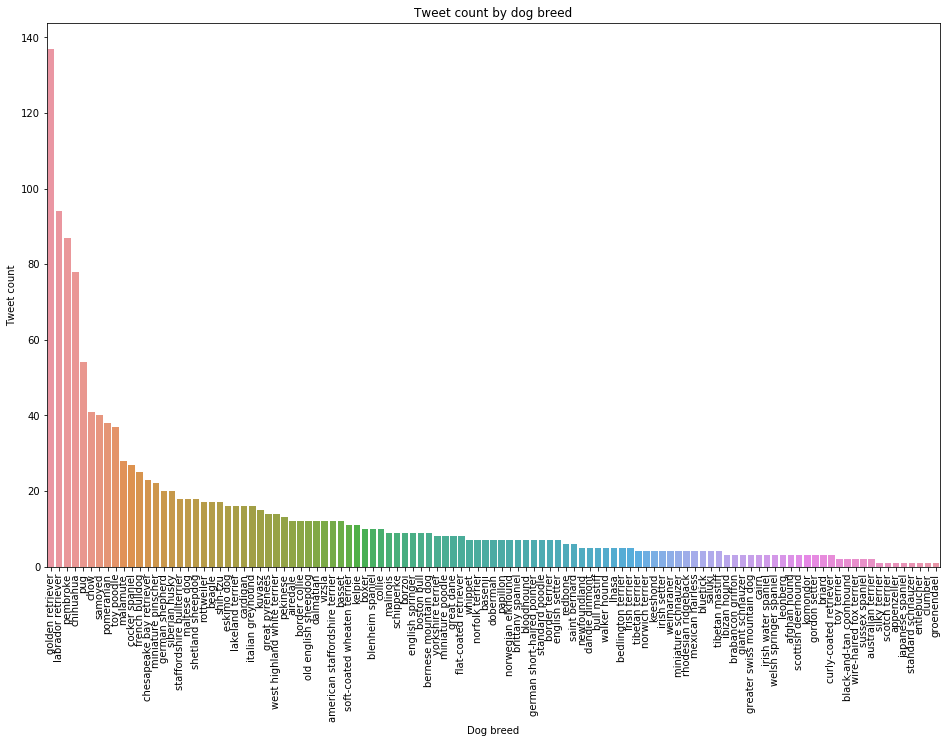

In [76]:
predicted_dogs = master.query('prediction1_dog == True')
fig, ax = plt.subplots(figsize=(16, 10))
plt.xticks(rotation=90)
sns.factorplot(
    data=predicted_dogs,
    x='prediction1',
    kind='count',
    order = predicted_dogs['prediction1'].value_counts().index,
    ax=ax)
ax.set(title='Tweet count by dog breed', xlabel='Dog breed', ylabel='Tweet count')
plt.close(2)
plt.savefig('tweet_count_by_dog_breed.png');

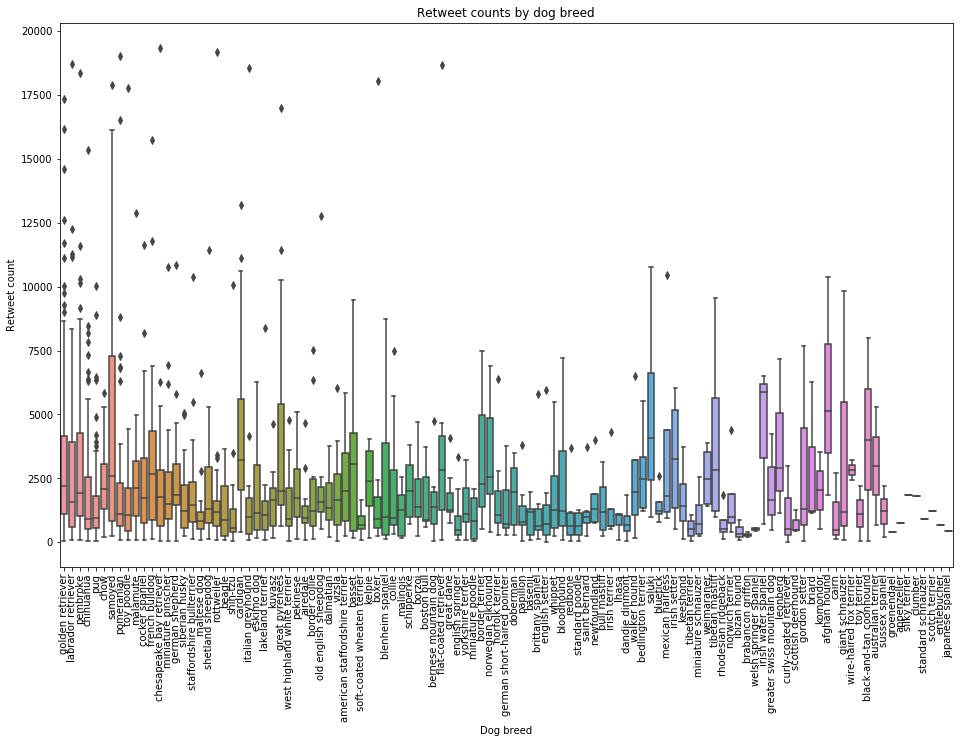

In [77]:
retweet_quantile_99 = master['retweet_count'].quantile(0.99)
predicted_dogs = master.query(f'prediction1_dog == True and retweet_count <= {retweet_quantile_99}')
fig, ax = plt.subplots(figsize=(16, 10))
plt.xticks(rotation=90)
sns.factorplot(
    data=predicted_dogs,
    x='prediction1',
    y='retweet_count',
    kind='box',
    order = predicted_dogs['prediction1'].value_counts().index,
    ax=ax)
ax.set(title='Retweet counts by dog breed', xlabel='Dog breed', ylabel='Retweet count')
plt.close(2)
plt.savefig('retweet_counts_by_dog_breed.png');

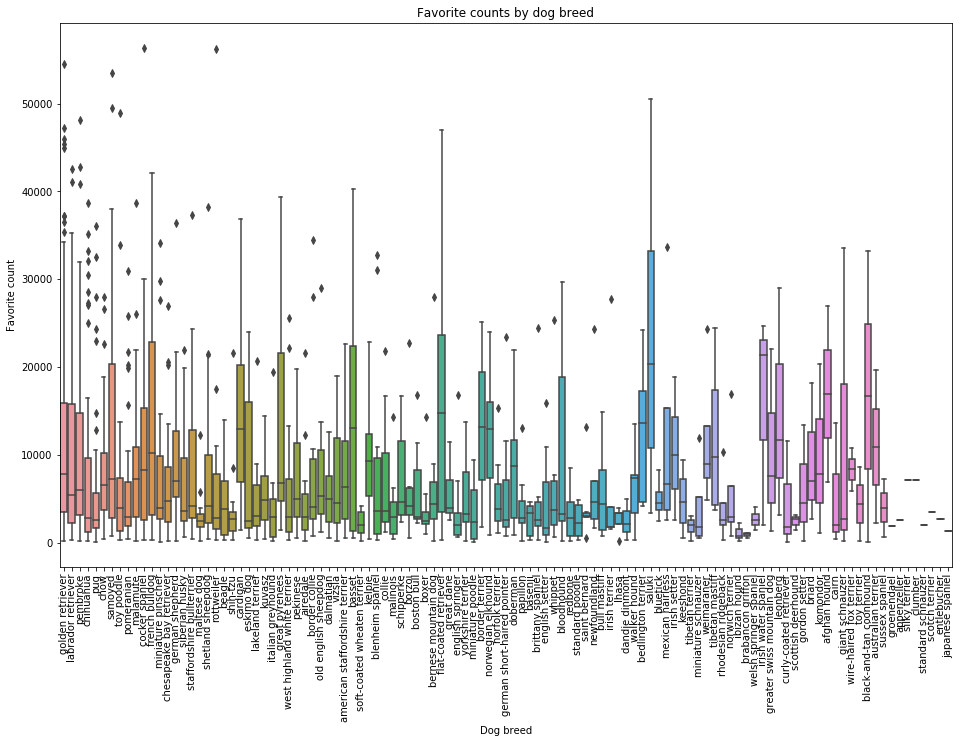

In [78]:
favorite_quantile_99 = master['favorite_count'].quantile(0.99)
predicted_dogs = master.query(f'prediction1_dog == True and favorite_count <= {favorite_quantile_99}')
fig, ax = plt.subplots(figsize=(16, 10))
plt.xticks(rotation=90)
sns.factorplot(
    data=predicted_dogs,
    x='prediction1',
    y='favorite_count',
    kind='box',
    order = predicted_dogs['prediction1'].value_counts().index,
    ax=ax)
ax.set(title='Favorite counts by dog breed', xlabel='Dog breed', ylabel='Favorite count')
plt.close(2)
plt.savefig('favorite_counts_by_dog_breed.png');

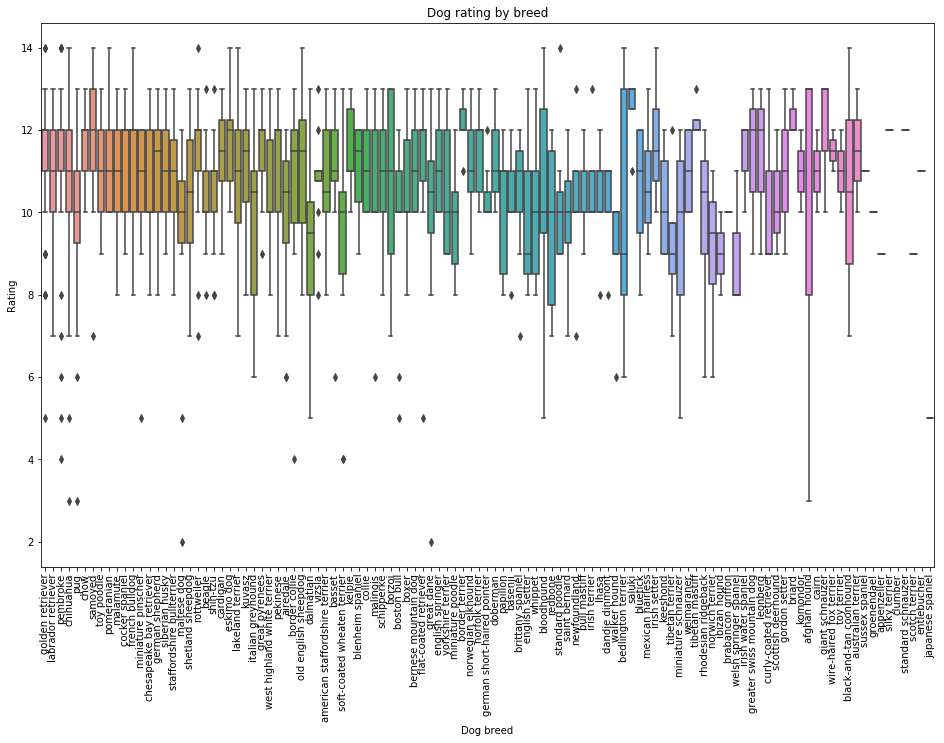

In [79]:
rating_quantile_99 = master['rating_with_denominator_10'].quantile(0.99)
dog_ratings = master.query(f'prediction1_dog == True and rating_with_denominator_10 <= {rating_quantile_99}')
fig, ax = plt.subplots(figsize=(16, 10))
plt.xticks(rotation=90)
sns.factorplot(
    data=dog_ratings,
    x='prediction1',
    y='rating_with_denominator_10',
    kind='box',
    order = predicted_dogs['prediction1'].value_counts().index,
    ax=ax)
ax.set(title='Dog rating by breed', xlabel='Dog breed', ylabel='Rating')
plt.close(2)
plt.savefig('dog_rating_by_breed.png');

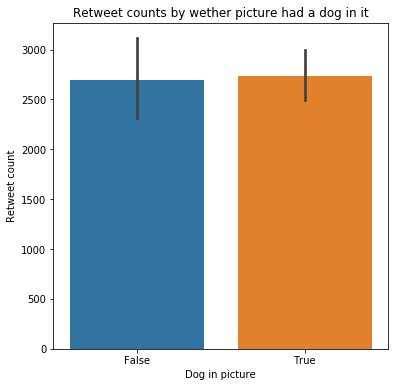

In [88]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.factorplot(
    data=master,
    x='prediction1_dog',
    y='retweet_count',
    kind='bar',
    ax=ax)
ax.set(title='Retweet counts by wether picture had a dog in it', xlabel='Dog in picture', ylabel='Retweet count')
plt.close(2)
plt.savefig('retweet_counts_by_wether_picture_had_a_dog_in_it.png');

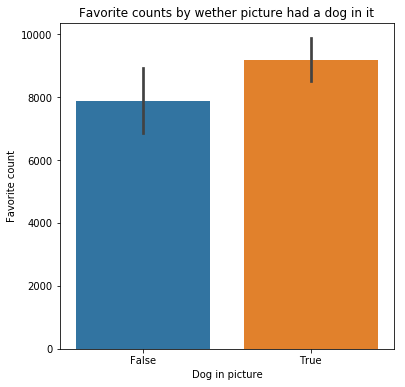

In [87]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.factorplot(
    data=master,
    x='prediction1_dog',
    y='favorite_count',
    kind='bar',
    ax=ax)
ax.set(title='Favorite counts by wether picture had a dog in it', xlabel='Dog in picture', ylabel='Favorite count')
plt.close(2)
plt.savefig('favorite_counts_by_wether_picture_had_a_dog_in_it.png');

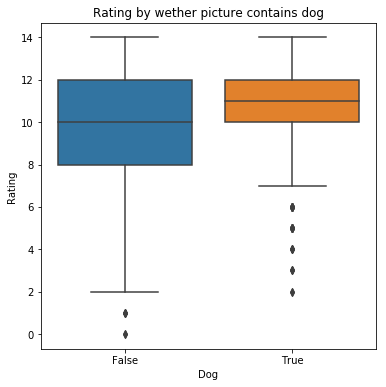

In [82]:
rating_quantile_99 = master['rating_with_denominator_10'].quantile(0.99)
dogs_with_ratings_under_q99 = master.query(f'rating_with_denominator_10 <= {rating_quantile_99}')
fig, ax = plt.subplots(figsize=(6, 6))
sns.factorplot(
    data=dogs_with_ratings_under_q99,
    x='prediction1_dog',
    y='rating_with_denominator_10',
    kind='box',
    ax=ax)
ax.set(title='Rating by wether picture contains dog', xlabel='Dog', ylabel='Rating')
plt.close(2)
plt.savefig('rating_by_wether_picture_contains_dog.png');

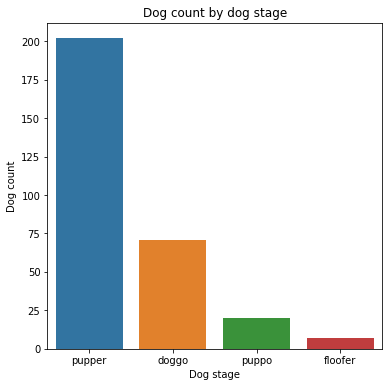

In [83]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.factorplot(
    data=master,
    x='stage',
    kind='count',
    ax=ax)
ax.set(title='Dog count by dog stage', xlabel='Dog stage', ylabel='Dog count')
plt.close(2)
plt.savefig('dog_count_by_dog_stage.png');

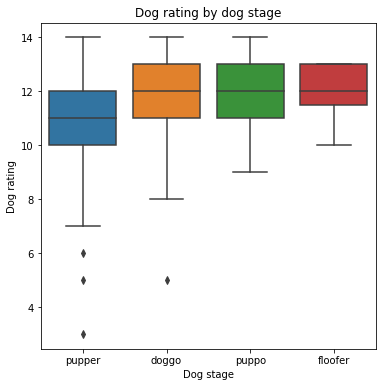

In [84]:
rating_quantile_99 = master['rating_with_denominator_10'].quantile(0.99)
dogs_with_ratings_under_q99 = master.query(f'rating_with_denominator_10 <= {rating_quantile_99}')
fig, ax = plt.subplots(figsize=(6, 6))
sns.factorplot(
    data=dogs_with_ratings_under_q99,
    x='stage',
    y='rating_with_denominator_10',
    kind='box',
    ax=ax)
ax.set(title='Dog rating by dog stage', xlabel='Dog stage', ylabel='Dog rating')
plt.close(2)
plt.savefig('dog_rating_by_dog_stage.png');

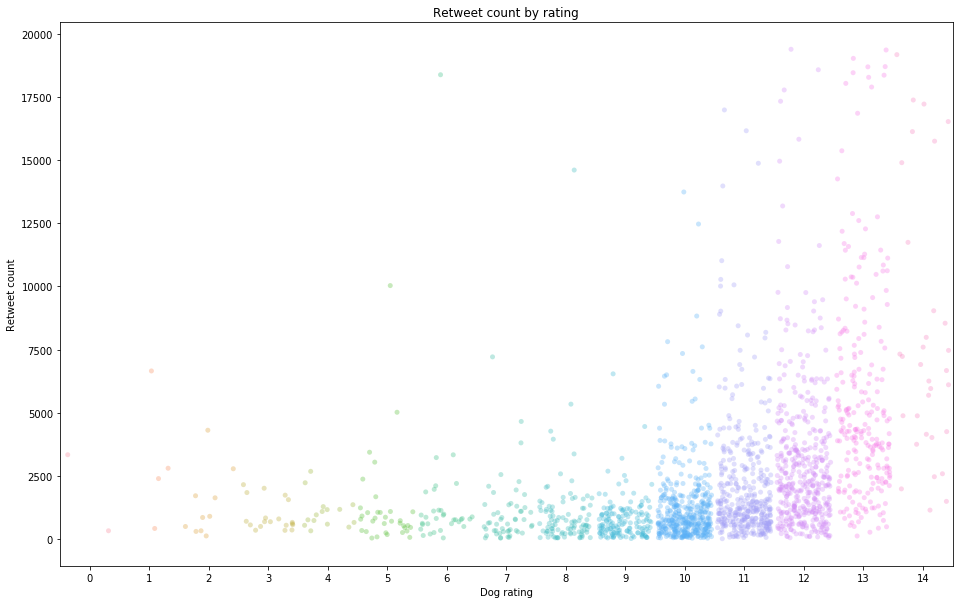

In [85]:
rating_quantile_99 = master['rating_with_denominator_10'].quantile(0.99)
retweet_quantile_99 = master['retweet_count'].quantile(0.99)
dogs = master.query(f'rating_with_denominator_10 <= {rating_quantile_99} and retweet_count <= {retweet_quantile_99}')
fig, ax = plt.subplots(figsize=(16, 10))
sns.stripplot(
    data=dogs,
    x='rating_with_denominator_10',
    y='retweet_count',
    jitter=0.45,
    alpha=0.33,
    ax=ax)
ax.set(title='Retweet count by rating', xlabel='Dog rating', ylabel='Retweet count')
plt.savefig('retweet_count_by_rating.png');

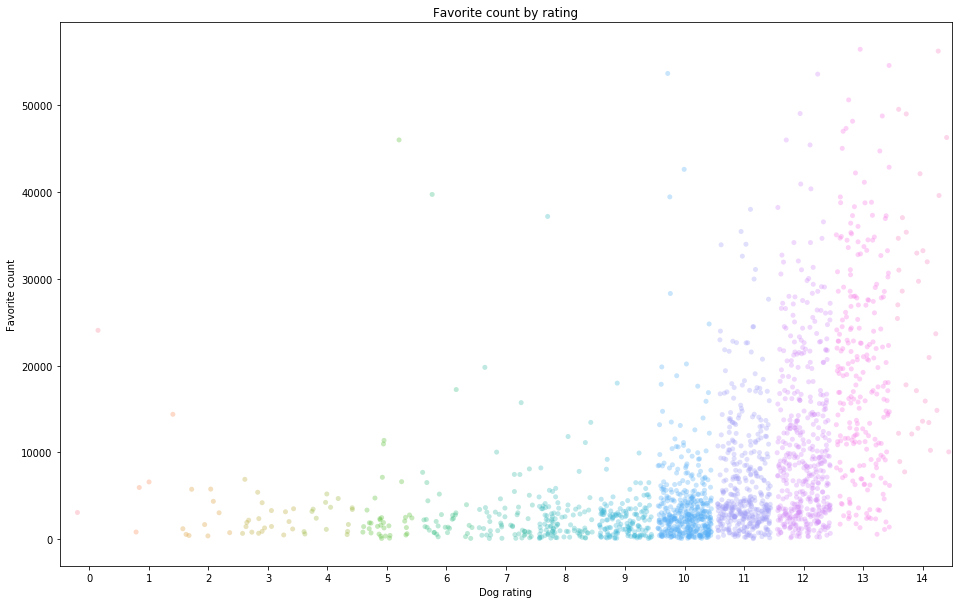

In [86]:
rating_quantile_99 = master['rating_with_denominator_10'].quantile(0.99)
favorite_quantile_99 = master['favorite_count'].quantile(0.99)
dogs = master.query(f'rating_with_denominator_10 <= {rating_quantile_99} and favorite_count <= {favorite_quantile_99}')
fig, ax = plt.subplots(figsize=(16, 10))
sns.stripplot(
    data=dogs,
    x='rating_with_denominator_10',
    y='favorite_count',
    jitter=0.45,
    alpha=0.33,
    ax=ax)
ax.set(title='Favorite count by rating', xlabel='Dog rating', ylabel='Favorite count')
plt.savefig('favorite_count_by_rating.png');

In [91]:
master.query('prediction1_dog == True').sort_values(['rating_with_denominator_10'], ascending=False).head()

,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,source,text,tweet_id,timestamp,expanded_urls,rating_numerator,...,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog,rating_with_denominator_10
1079,19866,NaN,NaN,6847,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",786709082849828864,2016-10-13 23:23:56,https://twitter.com/dog_rates/status/786709082...,75,...,pomeranian,0.467321,True,persian cat,0.122978,False,chow,0.102654,True,75
482,7143,NaN,NaN,1819,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. ...,778027034220126208,2016-09-20 00:24:34,https://twitter.com/dog_rates/status/778027034...,27,...,clumber,0.946718,True,cocker spaniel,0.015950,True,lhasa,0.006519,True,27
785,1830,NaN,NaN,528,Twitter for iPhone,Here we have uncovered an entire battalion of ...,680494726643068929,2015-12-25 21:06:00,https://twitter.com/dog_rates/status/680494726...,26,...,kuvasz,0.438627,True,samoyed,0.111622,True,great pyrenees,0.064061,True,26
873,33205,NaN,NaN,7983,Twitter for iPhone,Sometimes you guys remind me just how impactfu...,854120357044912130,2017-04-17 23:52:16,https://twitter.com/dog_rates/status/854120357...,14,...,black-and-tan coonhound,0.854861,True,doberman,0.050792,True,bluetick,0.021762,True,14
286,12203,855818117272018944,4196983835,1986,Twitter for iPhone,"THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",856526610513747968,2017-04-24 15:13:52,https://twitter.com/dog_rates/status/856526610...,14,...,old english sheepdog,0.798481,True,tibetan terrier,0.060602,True,standard poodle,0.040722,True,14


In [93]:
list(master.query('prediction1_dog == True').sort_values(['rating_with_denominator_10'], ascending=False)['text'].head())

["This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
 "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq",
 'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD',
 'Sometimes you guys remind me just how impactful a pupper can be. Cooper will be remembered as a good boy by so many. 14/10 rest easy friend https://t.co/oBL7LEJEzR',
 'THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA']

In [95]:
master.query('prediction1_dog == True').sort_values(['rating_with_denominator_10'], ascending=False)['jpg_url'].head()

1079    https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg
482     https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg
785     https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg
873     https://pbs.twimg.com/media/C9px7jyVwAAnmwN.jpg
286     https://pbs.twimg.com/media/C-L-aIYXgAIR0jY.jpg
Name: jpg_url, dtype: object